# Pet and Breed Category prediction

In [1]:
import math
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier, Pool

In [2]:
train_df = pd.read_csv('data/train.csv', parse_dates=['issue_date','listing_date'])
test_df = pd.read_csv('data/test.csv', parse_dates=['issue_date', 'listing_date'])

## Preprocessing

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18834 entries, 0 to 18833
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   pet_id          18834 non-null  object        
 1   issue_date      18834 non-null  datetime64[ns]
 2   listing_date    18834 non-null  datetime64[ns]
 3   condition       17357 non-null  float64       
 4   color_type      18834 non-null  object        
 5   length(m)       18834 non-null  float64       
 6   height(cm)      18834 non-null  float64       
 7   X1              18834 non-null  int64         
 8   X2              18834 non-null  int64         
 9   breed_category  18834 non-null  float64       
 10  pet_category    18834 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 1.6+ MB


### Finding missing values

In [4]:
train_df.isna().sum()

pet_id               0
issue_date           0
listing_date         0
condition         1477
color_type           0
length(m)            0
height(cm)           0
X1                   0
X2                   0
breed_category       0
pet_category         0
dtype: int64

Text(0.5, 0.98, 'Missing values in conditions vs response variables')

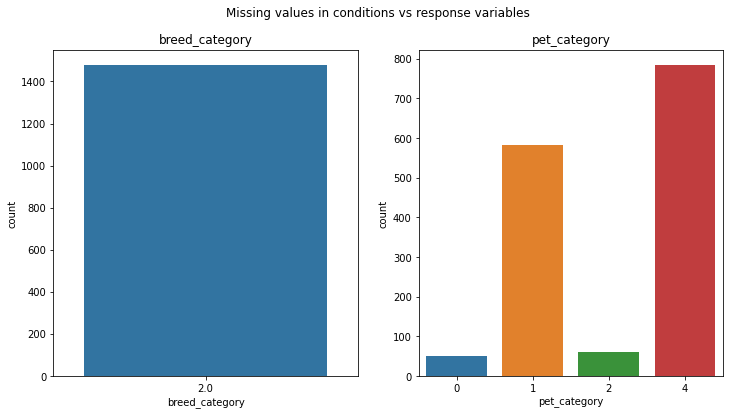

In [5]:
response_vars = ['breed_category', 'pet_category']

n = len(response_vars)
nrows = math.ceil(n/2)
ncols = 2

fig, ax = plt.subplots(nrows, ncols, sharex='col', figsize=(12, 6))

for index, value in enumerate(response_vars):
    sns.countplot(data=train_df[train_df['condition'].isna()][[value]],
                  x=value,
                  ax=ax[index])
    ax[index].set_title(value)
plt.suptitle("Missing values in conditions vs response variables")

### Univariate Analysis

In [6]:
def sns_cnt_plot(var):
    sns.set(rc={'figure.figsize': (12, 5), 'figure.dpi': 100})
    sns.countplot(data=train_df[[var]],
                  x=var, palette=sns.color_palette('coolwarm', 6))
    plt.xticks(rotation=45)
    plt.title(f'{var} count plot')
    plt.show()

In [7]:
train_df['color_type'] = train_df['color_type'].astype(str)
test_df['color_type'] = test_df['color_type'].astype(str)

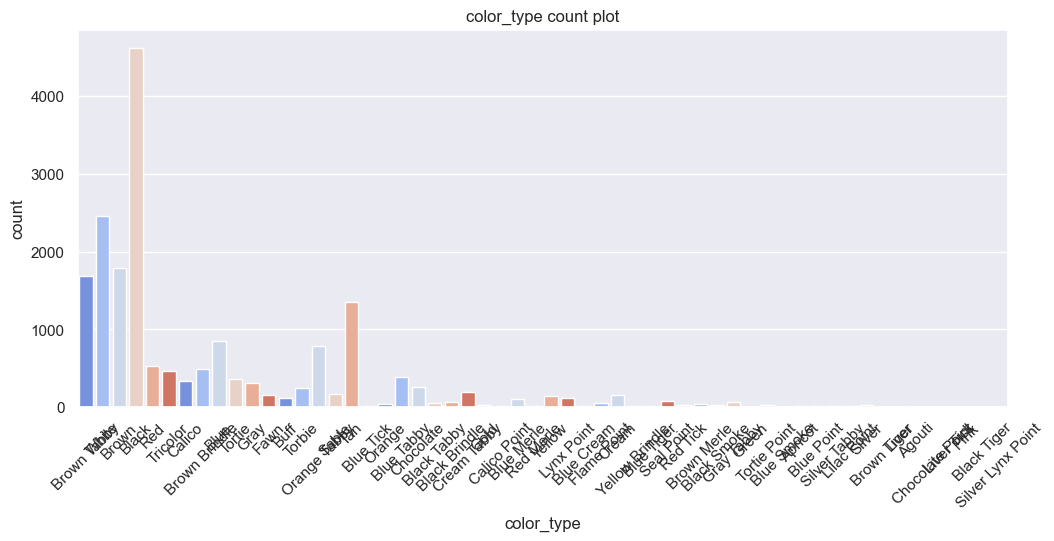

In [8]:
sns_cnt_plot('color_type')

In [9]:
train_df['X1'] = train_df['X1'].astype(np.int)
test_df['X1'] = test_df['X1'].astype(np.int)

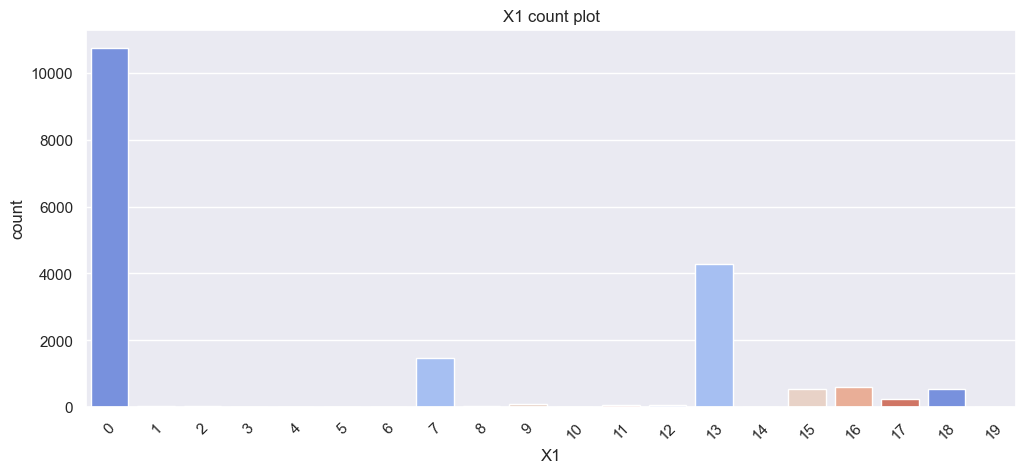

In [10]:
sns_cnt_plot('X1')

In [11]:
train_df['X2'] = train_df['X2'].astype(np.int)
test_df['X2'] = test_df['X2'].astype(np.int)

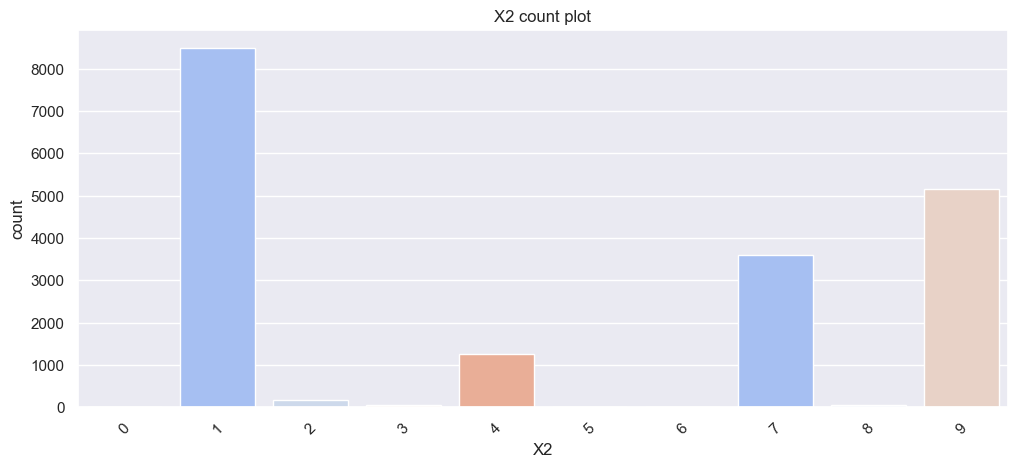

In [12]:
sns_cnt_plot('X2')

In [13]:
def sns_dist_plot(var):
    sns.set(rc={'figure.figsize':(12,5), 'figure.dpi':100})
    sns.distplot(train_df[[var]])
    plt.xticks(rotation=45)
    plt.title(f'{var} dist plot')
    plt.show()

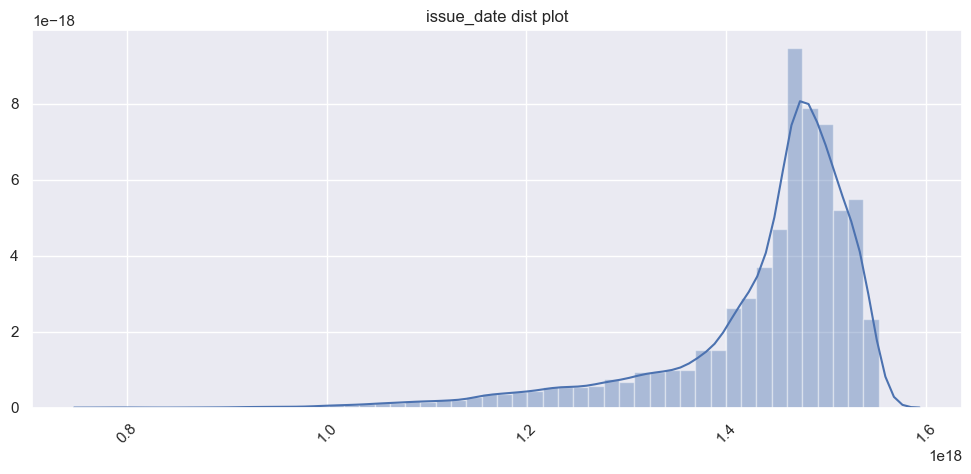

In [14]:
sns_dist_plot('issue_date')

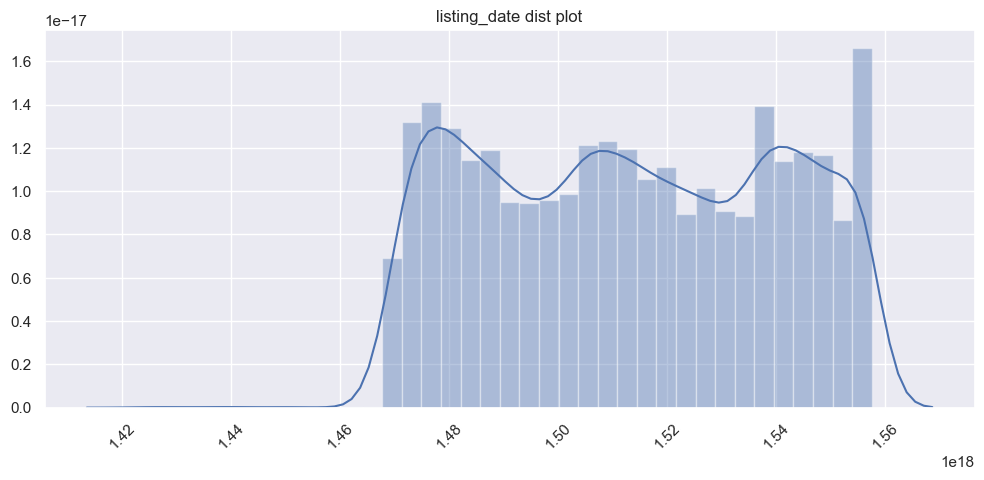

In [15]:
sns_dist_plot('listing_date')

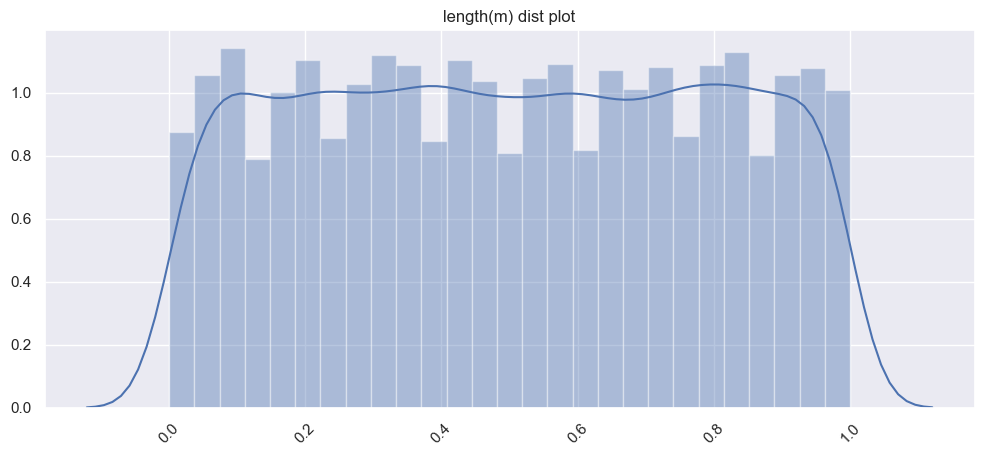

In [16]:
sns_dist_plot('length(m)')

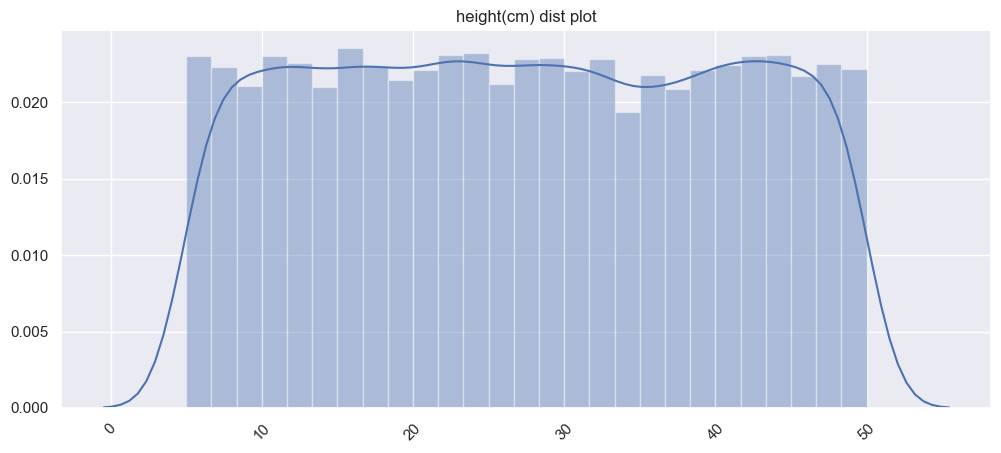

In [17]:
sns_dist_plot('height(cm)')

### Variable Mutation & Encoding

#### Calculating date difference

In [18]:
train_df['date_diff(hours)'] = train_df['listing_date'] - train_df['issue_date']
train_df['date_diff(hours)'] = train_df['date_diff(hours)']/datetime.timedelta(hours=1)

test_df['date_diff(hours)'] = test_df['listing_date'] - test_df['issue_date']
test_df['date_diff(hours)'] = test_df['date_diff(hours)']/datetime.timedelta(hours=1)

train_df['date_diff(hours)'] = train_df['date_diff(hours)'].astype(np.float)
test_df['date_diff(hours)'] = test_df['date_diff(hours)'].astype(np.float)

* Separating `issue_date` into its year, month and day
* If this doesn't work, change it to epoch

In [19]:
train_df['issue_year'] = train_df['issue_date'].dt.year
train_df['issue_month'] = train_df['issue_date'].dt.month
train_df['issue_day'] = train_df['issue_date'].dt.day

test_df['issue_year'] = test_df['issue_date'].dt.year
test_df['issue_month'] = test_df['issue_date'].dt.month
test_df['issue_day'] = test_df['issue_date'].dt.day

#### Changing unit of length

In [20]:
train_df['length(m)'] = train_df['length(m)'] * 100
test_df['length(m)'] = test_df['length(m)'] * 100

train_df.rename({'length(m)':'length(cm)'}, axis=1, inplace=True)
test_df.rename({'length(m)':'length(cm)'}, axis=1, inplace=True)

Dropping unnecessary columns

In [21]:
train_df.drop(['issue_date', 'listing_date'], axis=1, inplace=True)
test_df.drop(['issue_date', 'listing_date'], axis=1, inplace=True)

### Filling Missing Values

Filling NA values with mean of output for breed_category = 2

In [22]:
train_df[(train_df['breed_category'] == 2) & ~(train_df['condition'].isna())]['condition']

Series([], Name: condition, dtype: float64)

Since there are none, fill in with a new unique value

In [23]:
train_df['condition'].unique()

array([ 2.,  1., nan,  0.])

In [24]:
train_df.loc[train_df['condition'].isna(), 'condition'] = 3.0

In [25]:
train_df.isna().sum().sum()

0

In [26]:
test_df.loc[test_df['condition'].isna(), 'condition'] = 3.0

In [27]:
test_df.isna().sum().sum()

0

### Scaling

In [28]:
std_scaler = StandardScaler()

train_df[['date_diff(hours)']] = std_scaler.fit_transform(train_df[['date_diff(hours)']])
test_df[['date_diff(hours)']] = std_scaler.transform(test_df[['date_diff(hours)']])

In [29]:
std_scaler = StandardScaler()

train_df[['length(cm)']] = std_scaler.fit_transform(train_df[['length(cm)']])
test_df[['length(cm)']] = std_scaler.transform(test_df[['length(cm)']])

In [30]:
std_scaler = StandardScaler()

train_df[['height(cm)']] = std_scaler.fit_transform(train_df[['height(cm)']])
test_df[['height(cm)']] = std_scaler.transform(test_df[['height(cm)']])

## Correlation Matrix

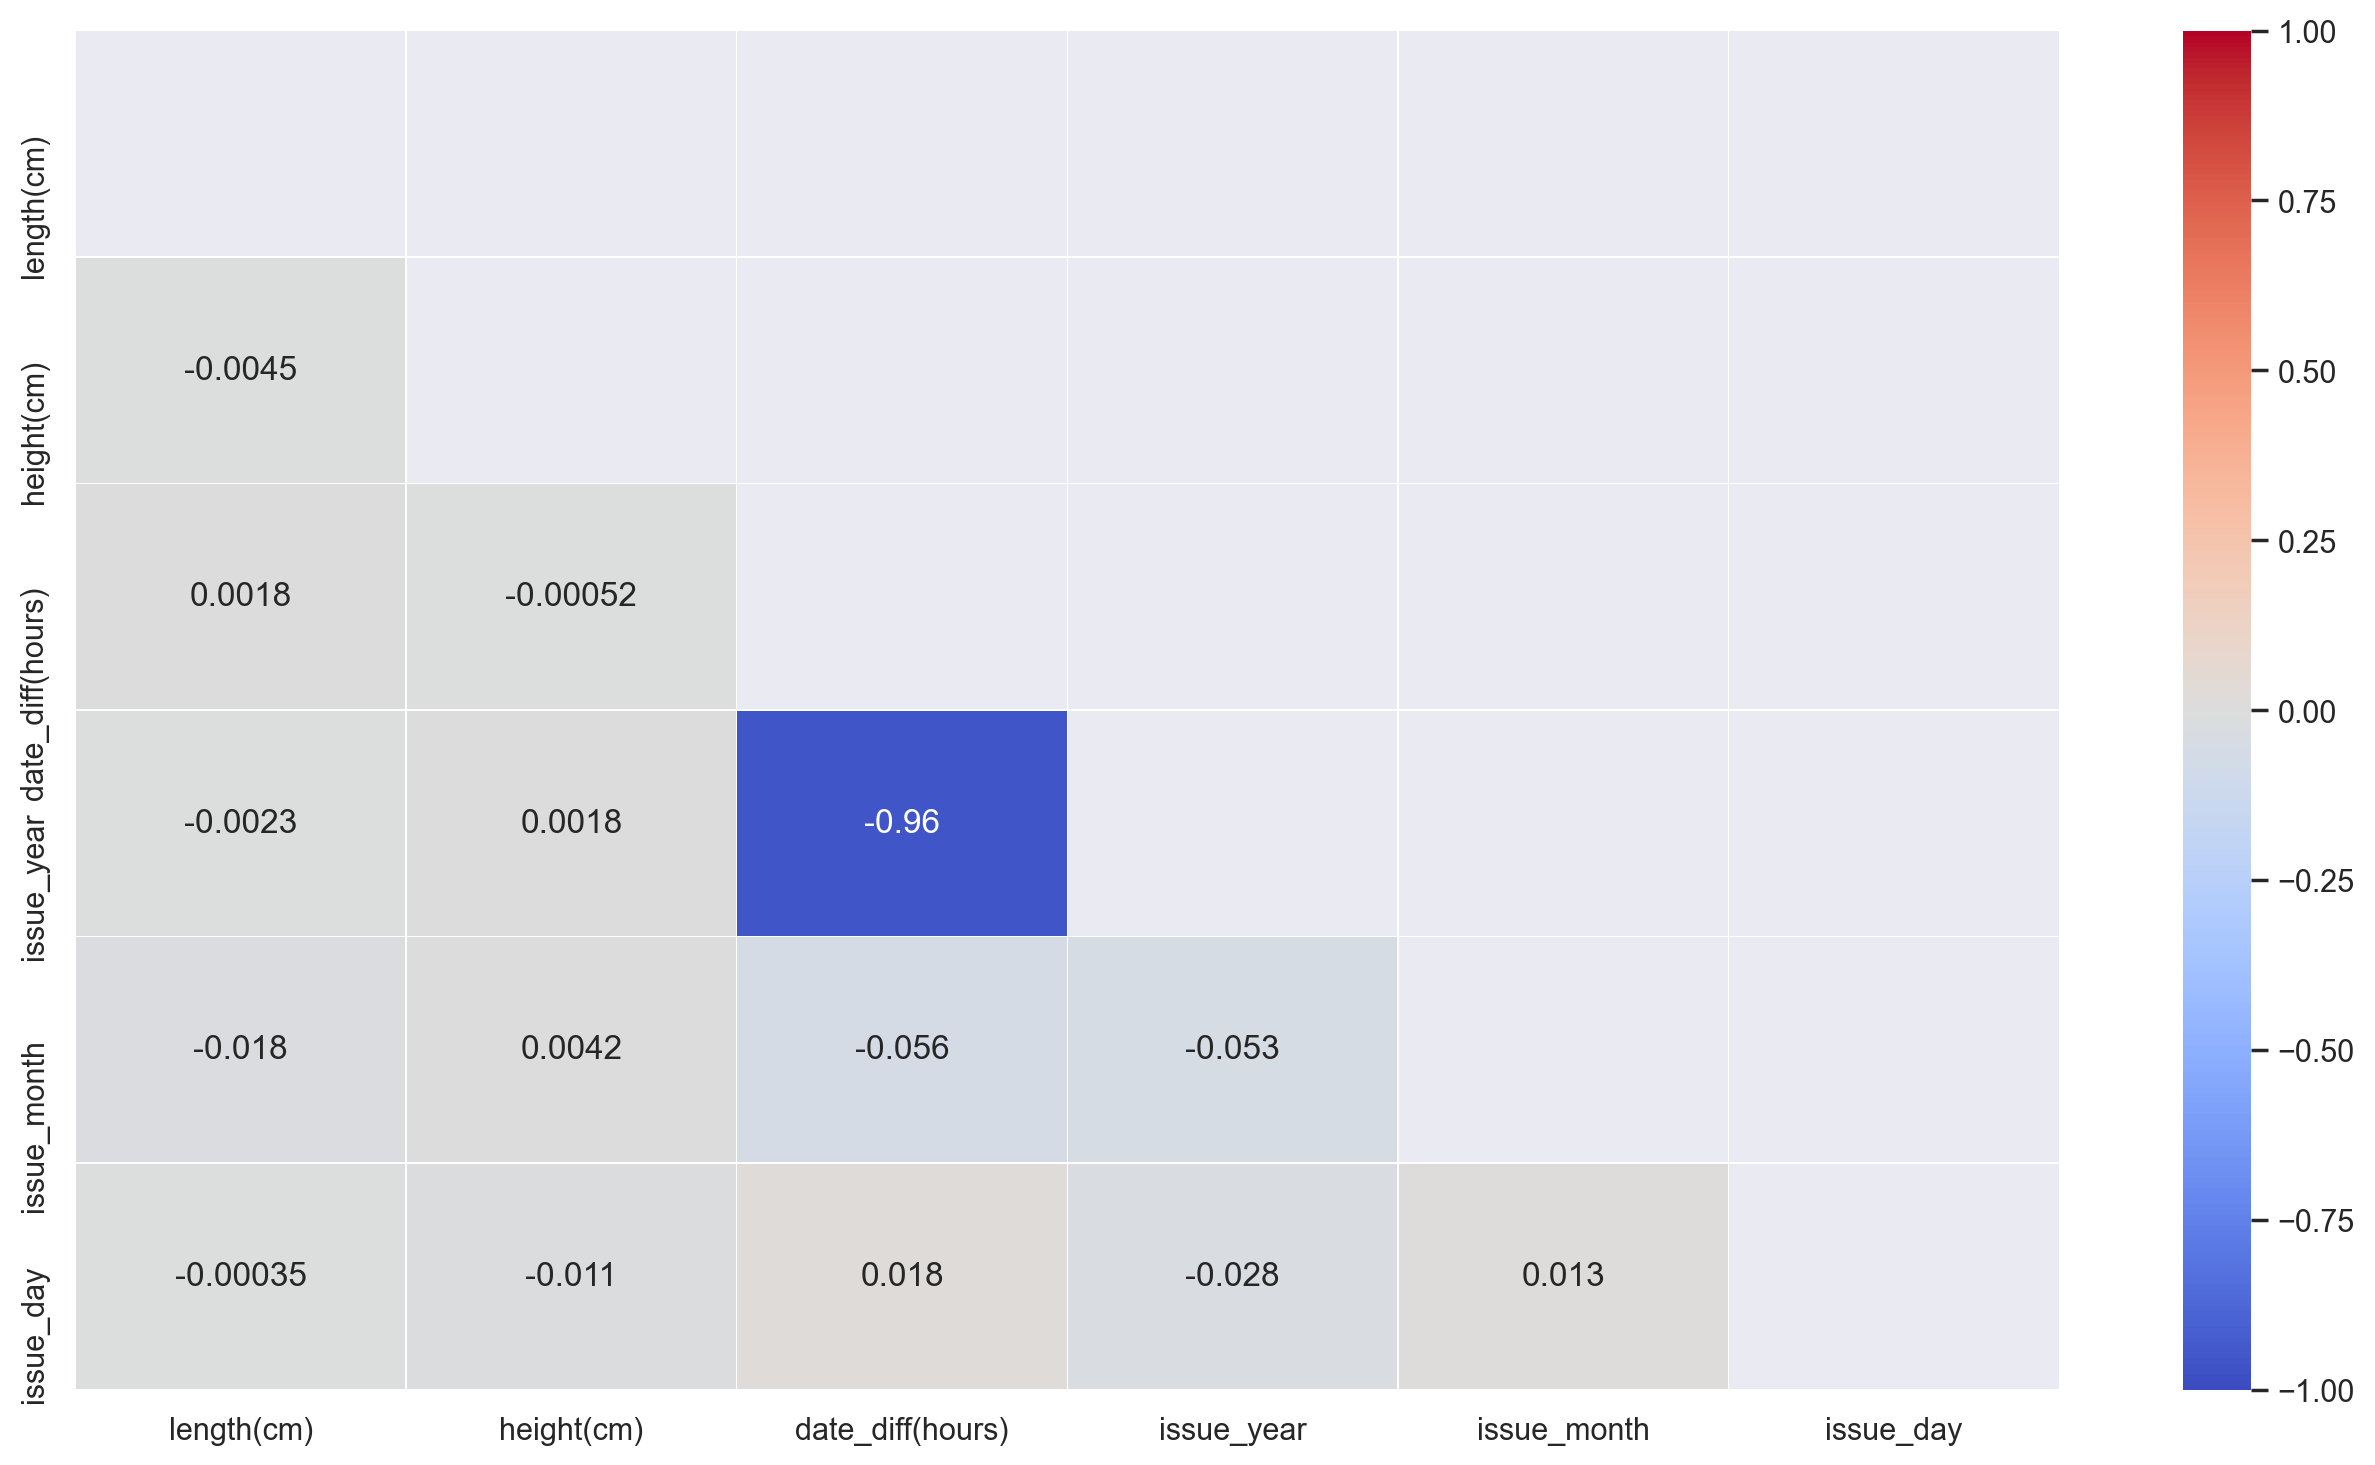

In [31]:
plt.figure(figsize=(16, 9), dpi=200)
corr_plot = train_df[['length(cm)', 'height(cm)', 'date_diff(hours)', 'issue_year',
                      'issue_month', 'issue_day', ]].corr()
mask = np.zeros_like(corr_plot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_plot,
            square=False,
            linewidth=.1,
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot=True,
            mask=mask)
plt.show()

In [32]:
# dropping issue_year
train_df.drop(['issue_year'], axis=1, inplace=True)
test_df.drop(['issue_year'], axis=1, inplace=True)

## Prediction

### `Breed_Category`

#### Grid Search

In [33]:
# changing remaining datatypes for catboost
train_df['breed_category'] = train_df['breed_category'].astype(np.int)

train_df['pet_category'] = train_df['pet_category'].astype(np.int)

train_df['issue_month'] = train_df['issue_month'].astype(np.int)
test_df['issue_month'] = test_df['issue_month'].astype(np.int)

train_df['issue_day'] = train_df['issue_day'].astype(np.int)
test_df['issue_day'] = test_df['issue_day'].astype(np.int)

train_df['condition'] = train_df['condition'].astype(np.int)
test_df['condition'] = test_df['condition'].astype(np.int)

In [34]:
grid_breed_pool = Pool(data=train_df.drop(['pet_category', 'breed_category', 'pet_id'], axis=1),
                       label=train_df[['breed_category']],
                       cat_features=['condition', 'color_type', 'X1', 'X2', 'issue_month', 'issue_day'])

In [35]:
cat_breed_classifer = CatBoostClassifier(iterations= 2500, 
                                         silent= True,
                                         loss_function= 'MultiClass',
                                         eval_metric= 'TotalF1',
                                         random_seed= 2504,
                                         auto_class_weights='SqrtBalanced')

In [36]:
grid = {'learning_rate': [0.03, 0.06, 0.1], 
        'depth': [4, 6, 10], 
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [37]:
# grid_search_result = cat_breed_classifer.grid_search(grid,
#                                                      stratified=True,
#                                                      cv=3,
#                                                      X=grid,
#                                                      plot=True)

#### Training

In [38]:
cat_breed_classifer = CatBoostClassifier(iterations=5000,
                                         silent= True,
                                         loss_function= 'MultiClass',
                                         eval_metric= 'TotalF1',
                                         random_seed= 2504,
                                         auto_class_weights='SqrtBalanced', 
                                         depth=4, 
                                         learning_rate=0.06,
                                         l2_leaf_reg=5)

In [39]:
cat_breed_classifer.fit(X=grid_breed_pool,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Test predictions

In [40]:
test_df['breed_category'] = cat_breed_classifer.predict(test_df.drop(['pet_id'], axis=1))

### `Pet_category`

#### Grid Search

In [41]:
grid_pet_pool = Pool(data=train_df.drop(['pet_category', 'breed_category','pet_id'], axis=1),
                     label=train_df[['pet_category']],
                     cat_features=['condition', 'color_type', 'X1', 'X2', 
                                   'issue_month', 'issue_day'])

In [42]:
cat_pet_classifer = CatBoostClassifier(iterations= 2500, 
                                       silent= True,
                                       loss_function= 'MultiClass',
                                       eval_metric= 'TotalF1',
                                       random_seed= 2504,
                                       auto_class_weights='SqrtBalanced')

In [43]:
grid = {'learning_rate': [0.03, 0.06, 0.1], 
        'depth': [4, 6, 10], 
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [44]:
# grid_search_result = cat_pet_classifer.grid_search(grid,
#                                                    stratified=True,
#                                                    cv=3,
#                                                    X=grid_pet_pool,
#                                                    plot=True)

#### Training

In [45]:
cat_pet_classifer = CatBoostClassifier(iterations=5000,
                                       silent= True,
                                       loss_function= 'MultiClass',
                                       eval_metric= 'TotalF1',
                                       random_seed= 2504,
                                       auto_class_weights='SqrtBalanced', 
                                       depth=4, 
                                       learning_rate=0.06,
                                       l2_leaf_reg=5)

In [46]:
cat_pet_classifer.fit(X=grid_pet_pool,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Test Predictions

In [47]:
test_df['pet_category'] = cat_pet_classifer.predict(test_df.drop(['pet_id', 'breed_category'], axis=1))

## Saving Output

In [48]:
test_final = pd.read_csv('data/test.csv')

In [49]:
test_final = pd.merge(test_final[['pet_id']], test_df[['pet_id', 'breed_category', 'pet_category']], on='pet_id')

In [50]:
test_final.to_csv('output/output.csv', index=False)